# Automated ML

TODO: Import Dependencies. In the cell below, import all the dependencies that you will need to complete the project.

In [4]:
import azureml.core
import pandas as pd
from azureml.core.workspace import Workspace
from azureml.train.automl.run import AutoMLRun
import time
import logging
from sklearn import datasets
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
import random
import numpy as np

import os
import pandas as pd
import numpy as np
import json
import requests
import joblib
from sklearn.metrics import confusion_matrix
import itertools
import time
import logging

from azureml.core import Dataset, Workspace, Experiment
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException
from azureml.widgets import RunDetails
from azureml.train.automl import AutoMLConfig

from azureml.core.experiment import Experiment
from azureml.core.model import InferenceConfig
from azureml.core.webservice import AciWebservice, Webservice
from azureml.core.model import Model
from azureml.core.environment import Environment

In [5]:
ws = Workspace.from_config()
print(ws.name, ws.resource_group, ws.location, ws.subscription_id, sep = '\n')

quick-starts-ws-137788
aml-quickstarts-137788
southcentralus
48a74bb7-9950-4cc1-9caa-5d50f995cc55


In [6]:
# choose a name for experiment
experiment_name = 'MNIST_Experiment_1'
project_folder = './'

experiment = Experiment(ws, experiment_name)
experiment

Name,Workspace,Report Page,Docs Page
MNIST_Experiment_1,quick-starts-ws-137788,Link to Azure Machine Learning studio,Link to Documentation


In [7]:
import os

output = {}
output['SDK version'] = azureml.core.VERSION
output['Subscription ID'] = ws.subscription_id
output['Workspace'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Project Directory'] = project_folder
pd.set_option('display.max_colwidth', -1)
pd.DataFrame(data=output, index=['']).T

,
SDK version,1.20.0
Subscription ID,48a74bb7-9950-4cc1-9caa-5d50f995cc55
Workspace,quick-starts-ws-137788
Resource Group,aml-quickstarts-137788
Location,southcentralus
Project Directory,./


## Create or Attach an AmlCompute cluster

In [8]:
cpu_cluster_name = "AUTOML-cluster"

# Verify that cluster does not exist already
try:
    compute_target = ComputeTarget(workspace=ws, name=cpu_cluster_name)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_D12_V2',
                                                           max_nodes=5)
    compute_target = ComputeTarget.create(ws, cpu_cluster_name, compute_config)

compute_target.wait_for_completion(show_output=True)

Creating
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


## Dataset

### Overview
TODO: In this markdown cell, give an overview of the dataset you are using. Also mention the task you will be performing.


TODO: Get data. In the cell below, write code to access the data you will be using in this project. Remember that the dataset needs to be external.

In [9]:
from sklearn import datasets

digits = datasets.load_digits()

# Exclude the first 100 rows from training so that they can be used for test.
X_train = digits.data[100:,:]
y_train = digits.target[100:]

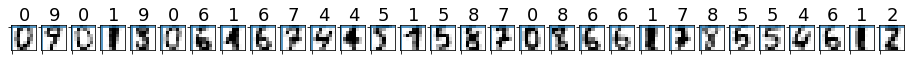

In [10]:
count = 0
sample_size = 30
plt.figure(figsize = (16, 6))
for i in np.random.permutation(X_train.shape[0])[:sample_size]:
    count = count + 1
    plt.subplot(1, sample_size, count)
    plt.axhline('')
    plt.axvline('')
    plt.text(x = 2, y = -2, s = y_train[i], fontsize = 18)
    plt.imshow(X_train[i].reshape(8, 8), cmap = plt.cm.Greys)
plt.show()

In [11]:
from sklearn import datasets
from azureml.core.dataset import Dataset
from scipy import sparse
import numpy as np
import pandas as pd
import os

# Create a project_folder if it doesn't exist
if not os.path.isdir('data'):
    os.mkdir('data')
    
if not os.path.exists('project_folder'):
    os.makedirs('project_folder')

X = pd.DataFrame(digits.data[100:,:])
y = pd.DataFrame(digits.target[100:])

# merge X and y
label = "digit"
X[label] = y

training_data = X

training_data.to_csv('data/digits.csv')
ds = ws.get_default_datastore()
ds.upload(src_dir='./data', target_path='digitsdata', overwrite=True, show_progress=True)

training_data = Dataset.Tabular.from_delimited_files(path=ds.path('digitsdata/digits.csv'))

Uploading an estimated of 1 files
Uploading ./data/digits.csv
Uploaded ./data/digits.csv, 1 files out of an estimated total of 1
Uploaded 1 files


## AutoML Configuration

TODO: Explain why you chose the automl settings and cofiguration you used below.

In [13]:
# TODO: Put your automl settings here

automl_settings = {
    "name": "AutoML_Demo_Experiment_{0}".format(time.time()),
    "experiment_timeout_minutes" : 20,
    "enable_early_stopping" : True,
    "iteration_timeout_minutes": 10,
    "n_cross_validations": 5,
    "primary_metric": 'AUC_weighted',
    "max_concurrent_iterations": 10,
}

automl_config = AutoMLConfig(task='classification',
                             debug_log='automl_errors.log',
                             path=project_folder,
                             compute_target=compute_target,
                             training_data=training_data,
                             label_column_name=label,
                             **automl_settings,
                             )

In [14]:
# TODO: Submit your experiment
from azureml.core.experiment import Experiment
experiment=Experiment(ws, experiment_name)
remote_run = experiment.submit(automl_config, show_output=True)

Running on remote.
No run_configuration provided, running on AUTOML-cluster with default configuration
Running on remote compute: AUTOML-cluster
Parent Run ID: AutoML_3d5d6ba0-f3ac-4b65-82f1-eebd553cf63b

Current status: FeaturesGeneration. Generating features for the dataset.
Current status: DatasetCrossValidationSplit. Generating individually featurized CV splits.
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Class balancing detection
STATUS:       PASSED
DESCRIPTION:  Your inputs were analyzed, and all classes are balanced in your training data.
              Learn more about imbalanced data: https://aka.ms/AutomatedMLImbalancedData

****************************************************************************************************

TYPE:         Missing feature values imputation
STATUS:       PASSED
DESCRIPTION:  No feature missing val

## Run Details

OPTIONAL: Write about the different models trained and their performance. Why do you think some models did better than others?

TODO: In the cell below, use the `RunDetails` widget to show the different experiments.

In [15]:
from azureml.widgets import RunDetails
RunDetails(remote_run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

In [16]:
children = list(remote_run.get_children())
metricslist = {}
for run in children:
    properties = run.get_properties()
    metrics = {k: v for k, v in run.get_metrics().items() if isinstance(v, float)}
    metricslist[int(properties['iteration'])] = metrics

import pandas as pd
rundata = pd.DataFrame(metricslist).sort_index(1)
rundata

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
weighted_accuracy,0.970819,0.964709,0.865567,0.914493,0.927988,0.847546,0.921275,0.769292,0.912683,0.965527,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.993399,0.990451
recall_score_macro,0.972871,0.966956,0.867867,0.918368,0.928089,0.853908,0.922799,0.779906,0.914868,0.964939,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.993701,0.989389
f1_score_macro,0.971599,0.965691,0.865198,0.914825,0.926950,0.847563,0.922084,0.756580,0.912386,0.963804,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.993653,0.989791
f1_score_micro,0.971723,0.965832,0.866811,0.916340,0.928116,0.850909,0.922207,0.774335,0.913989,0.965239,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.993521,0.989984
average_precision_score_micro,0.995619,0.994407,0.933868,0.960601,0.975917,0.916103,0.974863,0.841809,0.963618,0.993327,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.999622,0.999193
matthews_correlation,0.968621,0.962129,0.852438,0.907503,0.920316,0.835427,0.913726,0.753180,0.904709,0.961492,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.992806,0.988878
balanced_accuracy,0.972871,0.966956,0.867867,0.918368,0.928089,0.853908,0.922799,0.779906,0.914868,0.964939,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.993701,0.989389
average_precision_score_macro,0.996110,0.994582,0.931303,0.962992,0.972584,0.914917,0.972474,0.851328,0.961779,0.991663,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.999529,0.999350
recall_score_micro,0.971723,0.965832,0.866811,0.916340,0.928116,0.850909,0.922207,0.774335,0.913989,0.965239,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.993521,0.989984
AUC_weighted,0.999341,0.999124,0.985896,0.992856,0.995109,0.981873,0.994865,0.965151,0.993055,0.998644,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.999936,0.999911


## Best Model

TODO: In the cell below, get the best model from the automl experiments and display all the properties of the model.



In [17]:
best_run, fitted_model = remote_run.get_output()
best_run_metrics = best_run.get_metrics()

Package:azureml-automl-runtime, training version:1.21.0, current version:1.20.0
Package:azureml-core, training version:1.21.0.post1, current version:1.20.0
Package:azureml-dataprep, training version:2.8.2, current version:2.7.3
Package:azureml-dataprep-native, training version:28.0.0, current version:27.0.0
Package:azureml-dataprep-rslex, training version:1.6.0, current version:1.5.0
Package:azureml-dataset-runtime, training version:1.21.0, current version:1.20.0
Package:azureml-defaults, training version:1.21.0, current version:1.20.0
Package:azureml-interpret, training version:1.21.0, current version:1.20.0
Package:azureml-pipeline-core, training version:1.21.0, current version:1.20.0
Package:azureml-telemetry, training version:1.21.0, current version:1.20.0
Package:azureml-train-automl-client, training version:1.21.0, current version:1.20.0
Package:azureml-train-automl-runtime, training version:1.21.0, current version:1.20.0


In [18]:
#TODO: Save the best model
os.makedirs('./outputs', exist_ok=True)

joblib.dump(fitted_model, filename='outputs/automl.joblib')

model_name = best_run.properties['model_name']
model_name

'AutoML3d5d6ba0f56'

## Model Deployment

Remember you have to deploy only one of the two models you trained.. Perform the steps in the rest of this notebook only if you wish to deploy this model.

TODO: In the cell below, register the model, create an inference config and deploy the model as a web service.

In [19]:
script_file = 'score.py'

best_run.download_file('outputs/scoring_file_v_1_0_0.py', script_file)

In [21]:
# register model in workspace
description = 'Automated Machine Learning Model'
tags = None
model1 = remote_run.register_model(model_name = model_name, description=description, tags=tags)
remote_run.model_id # Use this id to deploy the model as a web service in Azure

'AutoML3d5d6ba0f56'

In [22]:
remote_run.get_portal_url()
env = best_run.get_environment()

script_file = 'score.py'

inference_config = InferenceConfig(entry_script = script_file, environment = env)

aci_config = AciWebservice.deploy_configuration(cpu_cores = 1, memory_gb = 1)

aci_service_name = 'automl-mnist-classifier'
print(aci_service_name)

automl-mnist-classifier


In [23]:
print('Best Run Id: ', best_run.id)
print('\n Accuracy:', best_run_metrics['accuracy'])
print(fitted_model._final_estimator)
print(best_run.get_tags())

Best Run Id:  AutoML_3d5d6ba0-f3ac-4b65-82f1-eebd553cf63b_56

 Accuracy: 0.9935207357279194
PreFittedSoftVotingClassifier(classification_labels=None,
                              estimators=[('47',
                                           Pipeline(memory=None,
                                                    steps=[('minmaxscaler',
                                                            MinMaxScaler(copy=True,
                                                                         feature_range=(0,
                                                                                        1))),
                                                           ('svcwrapper',
                                                            SVCWrapper(C=51.79474679231202,
                                                                       break_ties=False,
                                                                       cache_size=200,
                                                 

In [30]:
service = Model.deploy(ws, aci_service_name, [model1], inference_config, aci_config)
service.wait_for_deployment(True)
print("State: " + service.state)
print("Scoring URI: " + service.scoring_uri)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running................................................
Succeeded
ACI service creation operation finished, operation "Succeeded"
State: Healthy
Scoring URI: http://1b456f09-aa6e-454d-a631-cbd51a1edcf7.southcentralus.azurecontainer.io/score


In [31]:
from azureml.automl.core.shared import constants
best_run.download_file(constants.CONDA_ENV_FILE_PATH, 'env.yml')

TODO: In the cell below, send a request to the web service you deployed to test it.

In [34]:
%run endpoint.py

POST to URL:  http://1b456f09-aa6e-454d-a631-cbd51a1edcf7.southcentralus.azurecontainer.io/score
label: 4
Prediction: 
{"result": [4]}


TODO: In the cell below, print the logs of the web service and delete the service

In [35]:
service.get_logs()

'2021-02-07T10:20:57,413389894+00:00 - rsyslog/run \n2021-02-07T10:20:57,415384413+00:00 - nginx/run \n2021-02-07T10:20:57,415694116+00:00 - iot-server/run \n/usr/sbin/nginx: /azureml-envs/azureml_20a8278aa8b20dd48cc50f56a6d2586c/lib/libcrypto.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n/usr/sbin/nginx: /azureml-envs/azureml_20a8278aa8b20dd48cc50f56a6d2586c/lib/libcrypto.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n/usr/sbin/nginx: /azureml-envs/azureml_20a8278aa8b20dd48cc50f56a6d2586c/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n/usr/sbin/nginx: /azureml-envs/azureml_20a8278aa8b20dd48cc50f56a6d2586c/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n/usr/sbin/nginx: /azureml-envs/azureml_20a8278aa8b20dd48cc50f56a6d2586c/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n2021-02-07T10:20:57,418093338+00:00 - gunicorn/run 

## Cleanup Resources

In [36]:
service.delete()